GenerateFramesFiles.ipynb

Maria Okounkova 

Notebook for generating frames files for LIGO data analysis, whether from NR simulation .h5 files, or using the a gravitational waveform surrogate model

### Imports and setup

In [102]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import h5py
from astropy import constants as const
from scipy.interpolate import InterpolatedUnivariateSpline
from pycbc.detector import Detector
from gwpy.timeseries import TimeSeries
from gwpy.detector import Channel
import os
from shutil import copyfile
import fileinput
import seaborn as sns
import math
from math import pi
import pycbc
from pycbc.filter.matchedfilter import overlap
import json

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams['ytick.labelsize'] = 24
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.size'] = 5
matplotlib.rcParams['legend.fontsize'] = 24
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 1

### Helper functions

In [11]:

## Helper functions
def Ramp(time, t_s, t_r):
    """ Ramp function for tapering the waveform"""
    if (time < t_s):
        return 0.0
    elif time > (t_s + t_r):
        return 1.0
    else:
        t = (time - t_s)/t_r
        return t**5*(126 + t*(-420 + t*(540 + t*(-315 + 70*t))))
    
def swsh(s, modes, theta, phi, psi=0):
    """
    Return a value of a spin-weighted spherical harmonic of spin-weight s. 
    If passed a list of several modes, then a numpy array is returned with 
    SWSH values of each mode for the given point.
    For one mode:       swsh(s,[(l,m)],theta,phi,psi=0)
    For several modes:  swsh(s,[(l1,m1),(l2,m2),(l3,m3),...],theta,phi,psi=0)
    """
    import spherical_functions as sf
    import quaternion as qt
    return sf.SWSH(qt.from_spherical_coords(theta, phi), s, modes) * np.exp(1j * s * psi)

def GetPeakTime(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(data)]
    return t_peak

def SubtractPeakTime(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTime(time, data)
    return time - t_peak

def dt_eval(time):
    """ Return the time step of a given time array """
    return (time[1] - time[0])

def df_eval(time):
    """ Return the delta_f of a given time array """
    delta_t = dt_eval(time)
    return 1.0/(time[-1] - time[0]) # + delta_t)

def EllinKm(ell_string, mass):
    """ Return the value of the dCS coupling constant in km """
    ell = float(ell_string.replace('p', '.'))
    mass_msun = mass * const.M_sun
    phys_ell_km = ell * mass_msun * const.G /(const.c**2) / 1000
    return phys_ell_km.value

def FullParamsDictionary(params_dict):
    """ Given a total mass, q > 1, and spins a_1, a_2, in params_dict, 
        compute m_1, m_2, m_chirp, and chi_eff and add to params_dict
         """
    mass = params_dict['mass']
    q = params_dict['q']
    a_1 = params_dict['a_1']
    a_2 = params_dict['a_2']
    
    m_2 = mass / (1 + q)
    m_1 = q*m_2
    m_chirp = (q/(1+q)**2)**(3/5)*mass
    
    params_dict['m_1'] = m_1
    params_dict['m_2'] = m_2
    params_dict['mass_ratio'] = 1.0/q
    params_dict['chirp_mass'] = m_chirp
    
    ## Assuming aligned spin for now 
    chi_eff = (a_1[2]/m_1 + a_2[2]/m_2)/mass
    params_dict['chi_eff'] = chi_eff
    
    return params_dict

def GetInjectedParameters(p):
    """ Return a dictionary of values from the parameters.json file 
        corresponding to the frames, where p is the path to the file """
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    f.close()
    return params

### Extrapolate the waveforms that we're interested in

Will have to do something like

`for N in -1 2 3 4 5 6; do mv rMPsi4_Extrapolated_N${N}.h5 rMDeltaPsi4_Extrapolated_N${N}.h5; done`

In [309]:
## Extrapolate the waveforms
for lev in [1, 2, 3, 4, 5]:
    scri.extrapolate(
        InputDirectory = 'Waveforms/Lev' + str(lev),
        OutputDirectory = 'Waveforms/Lev' + str(lev),
        DataFile = 'rh_FiniteRadii_CodeUnits.h5',
        #DataFile = 'rDeltaPsi4_FiniteRadii_CodeUnits.h5',
        ChMass = 1.0, 
        UseStupidNRARFormat = True, 
    )


Reading Waveforms from Waveforms/Lev1/rh_FiniteRadii_CodeUnits.h5...
Waveforms/Lev1/rh_FiniteRadii_CodeUnits.h5 passed the data-integrity tests.
R0163.dir, R0168.dir, R0173.dir, R0179.dir, R0185.dir, R0192.dir, R0199.dir, R0206.dir, R0215.dir, 
R0224.dir, R0234.dir, R0244.dir, R0256.dir, R0269.dir, R0283.dir, R0299.dir, R0316.dir, R0336.dir, 
R0359.dir, R0385.dir, R0414.dir, R0449.dir, R0490.dir, R0540.dir
Interpolating to common times...
Rotating into common (outer) frame...
Using alignment region (0.1, 0.8)
Running extrapolations.

N=-1: Rotating into inertial frame... ☺
N=-1: Writing Waveforms/Lev1/Extrapolated_N-1.h5... ☺
N=2: Rotating into inertial frame... ☺
N=2: Writing Waveforms/Lev1/Extrapolated_N2.h5... ☺
N=3: Rotating into inertial frame... ☺
N=3: Writing Waveforms/Lev1/Extrapolated_N3.h5... ☺
N=4: Rotating into inertial frame... ☺
N=4: Writing Waveforms/Lev1/Extrapolated_N4.h5... ☺
N=5: Rotating into inertial frame... ☺
N=5: Writing Waveforms/Lev1/Extrapolated_N5.h5... ☺
N=

### Read in the extrapolated waveforms

In [3]:
## Read in the extrapolated modes
def ReadExtrapolatedModes(file, params_dict, interpolate = True, apply_distance = True):
    """ 
        File is the file containing the extrapolated waveform that we want to read in.
        For params_dict, 
        mass_msun is the total mass of the system in solar masses, and 
        dist_mpc is the distance to the system in kpc. 
        theta and phi are angles determining the inclination.
        dt is the timestep (reciprocal of the sampling rate)
        
        If we want to interpolate the waveform to have even timesteps dt, then 
        set interpolate to True. Otherwise, we'll return the data without 
        performing the interpolation 

        """

    ## Convert distance to kpc and mass into solar masses
    mass = params_dict['mass']
    dist_mpc = params_dict['dist_mpc']
    theta = params_dict['theta']
    phi = params_dict['phi'] 
    dt = params_dict['dt']
    dist_kpc = dist_mpc * 1000 * const.kpc
    mass_msun = mass * const.M_sun
    
    ## Read in the data
    f = h5py.File(file, 'r')
    
    ## grab the length of the waveform first
    data = f['Extrapolated_N2.dir']['Y_l2_m2.dat']
    time = np.array(data[:,0])
    
    h_plus = np.zeros(len(time))
    h_cross = np.zeros(len(time))

    #modes = [(2, -2), (2,2)]
    modes = [(l,m) for l in range(2,5) for m in range(-l, l+1)]
    for mode in modes: 
        
        ## Grab the mode in question
        l = mode[0]
        m = mode[1]
        
        data = f['Extrapolated_N2.dir']['Y_l' + str(l) + '_m' + str(m) + '.dat']
        real = np.array(data[:,1])
        imag = np.array(data[:,2])
        coeff = real + 1j * imag
        
        ## Multiply by the corresponding spin-weighted spherical harmonic
        Ylm = swsh(-2, [(l,m)], theta=theta, phi=phi, psi=0) 
        h = coeff * Ylm 
        
        ## Add to our h_plus and h_cross computations
        h_plus = h_plus + np.real(h)
        h_cross = h_cross - np.imag(h) 
        
        
    ## Apply the astrophysical parameters
    time = time*mass_msun*const.G/(const.c**3)
    h_plus = h_plus*const.G*mass_msun/((const.c)**2*dist_kpc)
    h_cross = h_cross*const.G*mass_msun/((const.c)**2*dist_kpc)

    ## Taper the waveform and apply the ramp (need to start the waveform at zero for this)
    time = time - time[0]
    ramp = np.array([Ramp(t.value, 0.1, 0.3) for t in time])
    
    h_plus = h_plus * ramp
    h_cross = h_cross * ramp
    
    ## Now subtract off the peak time (this makes the spine interpolation easier)
    amp = np.sqrt(h_plus**2 + h_cross**2)
    time = time - time[np.argmax(amp)]
    
    if not interpolate:
        print("Not performing the interpolation")
        return time, h_plus, h_cross
    
    ## Now build the interpolants 
    cs_plus = InterpolatedUnivariateSpline(time, h_plus)
    cs_cross = InterpolatedUnivariateSpline(time, h_cross)

    ## Now create an evenly-spaced time array and interpolate the data 
    time_cs = np.arange(time[0].value, time[-1].value, dt)

    h_plus_cs = cs_plus(time_cs) 
    h_cross_cs = cs_cross(time_cs) 
    
    ## Return these new interpolated values
    return time_cs, h_plus_cs, h_cross_cs, np.sqrt(h_plus_cs**2 + h_cross_cs**2)
    

### Evaluate the surrogate

In [108]:
## Load in the surrogate
import gwsurrogate

## if you need the surrogate data: 
##gwsurrogate.catalog.pull('NRSur7dq4')

sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_sur

Loaded NRSur7dq4 model


In [17]:
## Surrogate evaluation
def EvaluateSurrogate(params_dict):
    """ Evaluate the surrogate waveform """
   
    """ Surrogate documentation: If inclination/phi_ref are specified, the complex strain (h =
             hplus -i hcross) evaluated at (inclination, pi/2 - phi_ref) on
             the sky of the reference frame is returned.

        In order to agree with NR convetions, need phi_ref = pi/2 - phi"""

    data = sur(params_dict['q'], params_dict['a_1'], params_dict['a_2'], \
               dt = params_dict['dt'], units = 'mks', M = params_dict['mass'], \
               dist_mpc = params_dict['dist_mpc'], f_low = params_dict['f_low'], \
               inclination = params_dict['theta'], ellMax = 4, phi_ref = pi/2 - params_dict['phi']) 

    time = data[0]
    h_plus = np.real(data[1])
    h_cross = -1 * np.imag(data[1])

    time = time - time[0]
    ramp = np.array([Ramp(t, 0.1, 0.3) for t in time])

    h_plus = h_plus * ramp
    h_cross = h_cross * ramp

    ## Now subtract off the peak time (this makes the spine interpolation easier)
    amp = np.sqrt(h_plus**2 + h_cross**2)
    time = time - time[np.argmax(amp)]

    return time, h_plus, h_cross, np.sqrt(h_plus**2 + h_cross**2)
        

### Pad the data in time and project to detectors

In [14]:
## Time padding and projection to detectors
def ProjectToDetectors(ra, dec, pol, t0, plus, cross, time):
    '''
    ra - Right Ascension
    dec - Declination
    pol - Polarization Angle
    t0 - reference time for when signal reaches Hanford
    '''
    
    ## Grab the dt
    dt = dt_eval(time)
    
    d_H1 = Detector("H1")
    d_L1 = Detector("L1")
    d_V1 = Detector("V1")
    
    # The time delay of the signal between the detectors
    t_delay_LH = d_L1.time_delay_from_detector(d_H1, ra, dec, t0)
    t_delay_VH = d_V1.time_delay_from_detector(d_H1, ra, dec, t0)
    
    # Round the delay time to the nearest dt (this assumes that t_gps is a multiple of dt)
    t_delay_rounded_LH = round(t_delay_LH / dt) * dt
    t_delay_rounded_VH = round(t_delay_VH / dt) * dt

    #Antenna Patterns
    Fp_H1, Fc_H1 = d_H1.antenna_pattern(ra, dec, pol, t0)
    Fp_L1, Fc_L1 = d_L1.antenna_pattern(ra, dec, pol, t0 + t_delay_rounded_LH)
    Fp_V1, Fc_V1 = d_V1.antenna_pattern(ra, dec, pol, t0 + t_delay_rounded_VH)
    
    
    #project
    h_H1 = Fp_H1*plus + Fc_H1*cross
    h_L1 = Fp_L1*plus + Fc_L1*cross
    h_V1 = Fp_V1*plus + Fc_V1*cross
    
    #Shift times
    time_H1 = time
    time_L1 = time + t_delay_rounded_LH
    time_V1 = time + t_delay_rounded_VH
    
    return time_H1, h_H1, time_L1, h_L1, time_V1, h_V1

def PadZeroes(time, strain, t_gps, peak_time_in_segment, segment_length):

    ## Now to pad the data with zeros -- we want to pad both the H1 and L1 data so that 
    ## they span the same gps times
    dt = dt_eval(time)
    segment_start_time = t_gps - peak_time_in_segment
    segment_end_time = segment_start_time + segment_length
    
    ## Do Hanford first (see how much we need to pad in order to get )
    start_pad_time = time[0] - segment_start_time
    end_pad_time = segment_end_time - time[-1]
    
    ## Figure out how many integer zeroes to pad the data
    start_pad_zeros = start_pad_time / dt
    end_pad_zeros = end_pad_time / dt
    
    ## Pad the data with zeroes 
    strain_padded = np.pad(strain, (int(start_pad_zeros), int(end_pad_zeros)), 'constant', constant_values=(0.0, 0.0))
    time_padded = np.arange(0., segment_length + dt, dt) + segment_start_time

    return time_padded, strain_padded

    
def PadAndProject(time, h_plus, h_cross, params_dict):
    """ Given a time, h_plus, and h_cross array, pad the data to the desired segment length, and project 
        to detectors.
        Within params_dict, 
        t_gps is the gps time of the event
        peak_time_in_segment is the time within the segment corresponding to the peak of the waveform (in sec)
        segmentt_length is the length of the segment (in sec)
        ra is the right ascention
        dec is the declination
        pol is the polarization
        """
       
    ## Grab the dt
    dt = dt_eval(time)
    
    ## The present peak time in the gravitational waveform (in secs)
    ## This is not the gps time, but rather should be ~0 from the surrogate / NR waveform 
    t_peak = time[np.argmax(h_plus**2 + h_cross**2)]
    
    ## Shift the times by the gps time, so that the peak of the waveform (in Handford)
    ## is now at t_gps
    time = time + params_dict['t_gps']

    ## Double check the peak time
    t_peak = time[np.argmax(h_plus**2 + h_cross**2)]
    #print("Shifted peak time: ", t_peak)
    
    ## Project data to the detectors -- both timeH and timeL % dt will be zero
    timeH, strainH, timeL, strainL, timeV, strainV = ProjectToDetectors(ra=params_dict['ra'], dec=params_dict['dec'], \
                                                        pol=params_dict['pol'], t0=params_dict['t_gps'], \
                                                        plus=h_plus, cross=h_cross, time=time)
    
        
    ## Pad the data with zeros
    timeH, strainH = PadZeroes(timeH, strainH, params_dict['t_gps'], params_dict['peak_time_in_segment'], \
                                               params_dict['segment_length'])
    timeL, strainL = PadZeroes(timeL, strainL, params_dict['t_gps'], params_dict['peak_time_in_segment'], \
                                               params_dict['segment_length'])
    timeV, strainV = PadZeroes(timeV, strainV, params_dict['t_gps'], params_dict['peak_time_in_segment'], \
                                               params_dict['segment_length'])
    
    ## Return the projected data
    return timeH, strainH, timeL, strainL, timeV, strainV

### Write frames files

In [5]:
## Generate frames files from the Hanford and Livingston data

def GenerateFrames(name, timeH, strainH, timeL, strainL, timeV, strainV, params_dict):
    """ Generate frames files given hanford and livingston data.
        rh_dir is the directory base directory for the data 
        Also make bayeswave files if necessary """

    frames_dir = 'BilbyPE/' + name + '/Frames/'
    bilby_dir = 'BilbyPE/' + name + '/'
    
    os.makedirs(frames_dir)
    
    dt = dt_eval(timeH)
    segment_start = timeH[0]
    segment_length = timeH[-1] - timeH[0]
    
    H1 = TimeSeries(strainH,sample_rate=1/dt,epoch=timeH[0],channel="H1:LDAS_STRAIN")
    L1 = TimeSeries(strainL,sample_rate=1/dt,epoch=timeL[0],channel="L1:LDAS_STRAIN")
    V1 = TimeSeries(strainV,sample_rate=1/dt,epoch=timeV[0],channel="V1:LDAS_STRAIN")
    
    H1.write(frames_dir + "H1.gwf")
    L1.write(frames_dir + "L1.gwf")
    V1.write(frames_dir + "V1.gwf")
    
    ## Copy over the bilby files and replace path variables
    for file in ['aLIGOZeroDetHighPower-PSD_25Hz.txt', 'Frame.prior', 'Frames.py', 
                 'run_bilby.dag', 'run_bilby.sh', 'run_bilby.sub']:
        
        ## Copy over base file
        copyfile('BilbyPE/Files/' + file, bilby_dir + file)
        
        ## Replace path variables
        with fileinput.FileInput(bilby_dir + file, inplace=True) as f:
            for line in f:
                print(line.replace('FRAMES_DIR', name), end='')
            
    ## Logs directory for Bilby
    os.mkdir(bilby_dir + 'Logs')
    
    ## Bayeswave files
    bw_dir = bilby_dir + 'BayesWave'
    os.mkdir(bw_dir)
    
    # Make the bayeswave cache files
    start_dir = '/home/maria.okounkova/BeyondGRAnalysis/'
    with open(bw_dir + '/H1_Cache.lcf', 'a') as file:
        file.write("-\t-\t-\t-\tfile://localhost" + start_dir + frames_dir + 'H1.gwf' + '\n')
    with open(bw_dir + '/L1_Cache.lcf', 'a') as file:
        file.write("-\t-\t-\t-\tfile://localhost" + start_dir + frames_dir + 'L1.gwf' + '\n')
    with open(bw_dir + '/V1_Cache.lcf', 'a') as file:
        file.write("-\t-\t-\t-\tfile://localhost" + start_dir + frames_dir + 'V1.gwf' + '\n')
        
    # Copy over the bayewave ini files
    copyfile('run_bw.sh', bw_dir + '/run_bw.sh')
    copyfile('dCS.ini', bw_dir + '/dCS.ini')
    
    # Change the path to the cache files in the copied dCS.ini file
    with fileinput.FileInput(bw_dir + '/dCS.ini', inplace=True) as file:
        for line in file:
            print(line.replace('CACHE_DIR', bw_dir), end='')
            
        

### Compute SNR

In [6]:
def ComputeSNR(time, strain):
    """ Given a time-domain strain and the corresponding time array, 
        compute the SNR using pycbc """

    ## Compute dt and df
    delta_t = dt_eval(time)
    delta_f = df_eval(time)
    
    ## Read in PSD and construct interpolant
    psd_file = "PSDs/design/aLIGOZeroDetHighPower-PSD_25Hz.txt"
    psd_frequencies, psd_vals = np.loadtxt(psd_file, comments="#",usecols=([0,1]),unpack=True)
    cs = InterpolatedUnivariateSpline(psd_frequencies, psd_vals)

    ## Interpolated PSD onto df-spaced values
    freqs = delta_f * np.array(range(len(strain)))
    psd = cs(freqs)

    ## Timeseries and Frequency series objects for pycbc computation
    strain_ts = pycbc.types.timeseries.TimeSeries(strain, delta_t = delta_t, epoch = time[0])
    psd_fs = pycbc.types.frequencyseries.FrequencySeries(psd, delta_f = delta_f, epoch = time[0])

    ## Noise-weighted innner product with low and high frequency cut-offs
    overlap_val = overlap(vec1 = strain_ts, vec2 = strain_ts, psd = psd_fs, normalized = False, \
                         low_frequency_cutoff = 25.5, high_frequency_cutoff = 4096) 
    
    ## Take the square root of the overlap for the SNR
    return(np.sqrt(overlap_val))


def TargetSNR(timeH, strainH, timeL, strainL, timeV, strainV, params_dict, desired_snr):
    """ Update the distance for a given GW waveform in order to 
        achieve a target SNR in H1 [note that (SNR_H1 / SNR_L1) is 
        independent of the distance, and SNR scales with distance as
        SNR ~ 1 / distance
        """
    ## Compute the SNR as it stands
    current_snr = ComputeSNR(timeH, strainH)
    print('Current SNR ', current_snr)
    
    ## Grab the current distance
    current_dist = params_dict['dist_mpc']
    print('Current distance', current_dist)
    
    ## Update the current distance to achieve the desired snr
    updated_dist = current_dist * current_snr / desired_snr
    print('Updated distance', updated_dist)
    
    ## Update the distance in the waveforms 
    strainH = strainH * current_dist / updated_dist
    strainL = strainL * current_dist / updated_dist
    strainV = strainV * current_dist / updated_dist
    
    ## Update the distance in the dictionary
    params_dict['dist_mpc'] = updated_dist
    
    return strainH, strainL, strainV, params_dict
    

### Compute overlap

In [ ]:
def ComputeOverlap(time, strain1, strain2, normalized = True):
    """ Given a time-domain strain and the corresponding time array, 
        compute the SNR using pycbc 
        normalized corresponds to whether we want to normalize the overlap, 
        which we don't want to do to compute the overlap, but we do want to 
        do for a simple overlap """

    ## Compute dt and df
    delta_t = dt_eval(time)
    delta_f = df_eval(time)
    
    ## Read in PSD and construct interpolant
    psd_file = "PSDs/design/aLIGOZeroDetHighPower-PSD.txt"
    psd_frequencies, psd_vals = np.loadtxt(psd_file, comments="#",usecols=([0,1]),unpack=True)
    cs = InterpolatedUnivariateSpline(psd_frequencies, psd_vals)

    ## Interpolated PSD onto df-spaced values
    freqs = delta_f * np.array(range(len(time)))
    psd = cs(freqs)

    ## Timeseries and Frequency series objects for pycbc computation
    strain1_ts = pycbc.types.timeseries.TimeSeries(strain1, delta_t = delta_t, epoch = time[0])
    strain2_ts = pycbc.types.timeseries.TimeSeries(strain2, delta_t = delta_t, epoch = time[0])
    psd_fs = pycbc.types.frequencyseries.FrequencySeries(psd, delta_f = delta_f, epoch = time[0])

    overlap_val = overlap(vec1 = strain1_ts, vec2 = strain2_ts, psd = psd_fs, normalized = True, low_frequency_cutoff = 25, high_frequency_cutoff = 1024) 
    
    ## Take the square root of the overlap for the overlap
    return(np.sqrt(overlap_val))

### Compute waveforms

In [7]:
def EvaluateNRWaveform(p_in, p_out, params_dict, desired_snr, ell = "0p0"):
    
    time, h_plus, h_cross, amp = ReadExtrapolatedModes(p_in, params_dict, interpolate = True)
    timeH, strainH, timeL, strainL, timeV, strainV = PadAndProject(time, h_plus, h_cross, params_dict)
    
    ## Update distance for target SNR
    strainH, strainL, strainV, params_dict = TargetSNR(timeH, strainH, timeL, strainL, timeV, strainV, params_dict, desired_snr)
    GenerateFrames(p_out, timeH, strainH, timeL, strainL, timeV, strainV, params_dict)
    
    ## Compute SNRs
    SNR_H = ComputeSNR(timeH, strainH)
    SNR_L = ComputeSNR(timeL, strainL)
    SNR_V = ComputeSNR(timeV, strainV)
    
    ## Print out the parameter values
    params_dict = FullParamsDictionary(params_dict)
    params_dict['source'] = p_in
    params_dict['H_SNR'] = SNR_H
    params_dict['L_SNR'] = SNR_L
    params_dict['V_SNR'] = SNR_V
    params_dict['ell'] = ell 
    params_dict['ell_km'] = EllinKm(ell, params_dict['mass'])
    with open('BilbyPE/' + p_out + '/parameters.json', 'w') as fp:
        json.dump(params_dict, fp)
    fp.close()

def EvaluateSurrogateWaveform(p_out, params_dict, desired_snr):
    
    time, h_plus, h_cross, amp = EvaluateSurrogate(params_dict)
    timeH, strainH, timeL, strainL, timeV, strainV = PadAndProject(time, h_plus, h_cross, params_dict)
    
    ## Update distance for target SNR
    strainH, strainL, strainV, params_dict = TargetSNR(timeH, strainH, timeL, strainL, timeV, strainV, params_dict, desired_snr)
    GenerateFrames(p_out, timeH, strainH, timeL, strainL, timeV, strainV, params_dict)
    
    ## Compute SNRs
    SNR_H = ComputeSNR(timeH, strainH)
    SNR_L = ComputeSNR(timeL, strainL)
    SNR_V = ComputeSNR(timeV, strainV)
    
    ## Print out the parameter values
    params_dict = FullParamsDictionary(params_dict)
    params_dict['H_SNR'] = SNR_H
    params_dict['L_SNR'] = SNR_L
    params_dict['V_SNR'] = SNR_V
    with open('BilbyPE/' + p_out + '/parameters.json', 'w') as fp:
        json.dump(params_dict, fp)
    fp.close()

    
My_Params_Dict = {'dt' : 1/2048, 't_gps' : 1126259462.0, 'peak_time_in_segment' : 8.0, 'segment_length' : 16.0, \
               'dist_mpc' : 400.0, 'mass' : 68.0, 'q' : 1.2212532137858916, \
               'a_1' : [0, 0, 0.329892752405], 'a_2' : [0, 0, -0.439940981499], \
               'f_low' : 0, 'theta' : pi, 'phi' : 0, \
               'ra' : 1.952318922, 'dec' : -1.26967171703, 'pol' : 0.824043851821}
 
ell = '0p0'
SNR = 75
EvaluateNRWaveform('Waveforms/Lev5/dCS_Strain_' + ell + '.h5', 'Test_FullSearchNoTiltNoSkyLoc_35_0p99', My_Params_Dict, SNR, ell=ell)
#EvaluateSurrogateWaveform('Test_Sur_25_0p8', My_Params_Dict, SNR)
#for ell in ['0p0']: #, '0p25', '0p3', '0p35', '0p37']:
#    for SNR in [25]: #, 75, 125]:
#        EvaluateNRWaveform('Waveforms/Lev5/dCS_Strain_' + ell + '.h5', 'dCS_' + ell + '_' + str(SNR) + '_' + 'FullSearch', My_Params_Dict, SNR, ell=ell)

Current SNR  72.87170584877964
Current distance 400.0
Updated distance 388.64909786015807


### Plot the frame files

#### Plot frames files for dCS params

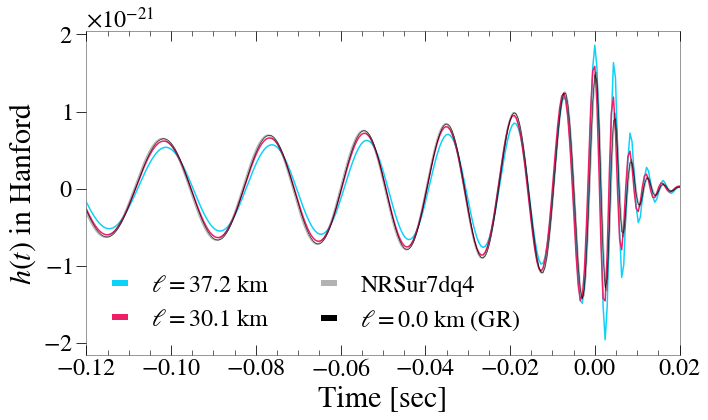

In [107]:
fig, ax = plt.subplots(figsize=(10, 6))

det = "H1"

base = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'

## Get injected paramters
truth_dict = GetInjectedParameters(base + 'dCS_0p0_75')
mass = truth_dict['mass']

p = base + 'dCS_0p37_75/Frames/'
sH = TimeSeries.read(source = p + det + '.gwf', channel=det+":LDAS_STRAIN")
tH = SubtractPeakTime(np.array(sH.times), sH)
plt.plot(tH, sH, '-', label='$\ell =  %.1f$' % EllinKm('0p37', mass) + ' km', lw=1.5, color='#0cd2fa')


p = base + 'dCS_0p3_75/Frames/'
sH = TimeSeries.read(source = p + det + '.gwf', channel=det+":LDAS_STRAIN")
tH = SubtractPeakTime(np.array(sH.times), sH)
plt.plot(tH, sH, '-', label='$\ell =  %.1f$' % EllinKm('0p3', mass) + ' km', lw=1.5, color='#ed1f67')


## Gr and surrogate plot
# Evaluate the surrogate for plotting
# surrogate_dict = truth_dict
# print(truth_dict)
# surrogate_dict['phi'] = -pi/4 + 0.05
# time_sur, h_plus_sur, h_cross_sur, amp_sur = EvaluateSurrogate(surrogate_dict)
# timeH_sur, strainH_sur, timeL_sur, strainL_sur, timeV_sur, strainV_sur = PadAndProject(time_sur, h_plus_sur, h_cross_sur, surrogate_dict)

# ## Plot the surrogate
# timeH_sur = SubtractPeakTime(timeH_sur, strainH_sur)
plt.plot(timeH_sur + 0.0003, strainH_sur, '-', label='NRSur7dq4', lw=2.0, alpha = 0.3, color='black')



p = base + 'dCS_0p0_75/Frames/'
sH = TimeSeries.read(source = p + det + '.gwf', channel=det+":LDAS_STRAIN")
tH = SubtractPeakTime(np.array(sH.times), sH)
plt.plot(tH, sH, '-', label='$\ell =  %.1f$' % EllinKm('0p0', mass) + ' km (GR)', lw=0.5, color='black')

#peak_time = truth_dict['t_gps']
#plt.xlim(peak_time - 0.15, peak_time + 0.02)
plt.xlim(-0.12, 0.02)
plt.xlabel('Time [sec]')
plt.ylabel(r'$h(t)$ in Hanford')
legend = plt.legend(fontsize=24, loc = 'lower left', ncol=2, frameon=False)
plt.grid()
plt.tight_layout()
plt.savefig('InjectedWaveforms.pdf')
plt.show()